In [1]:
import torch.optim as optim
import torch.cuda as cuda
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from os.path import exists
import torch
from UNET import UNET
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from Dataset import FramesDataset

In [2]:
BATCH = 1
EPOCHS = 1
LR = 0.0001
cuda.empty_cache()
scaler = GradScaler()
device = "cuda" if cuda.is_available() else "cpu"
dir_dataset = r'C:\Users\Mau\Desktop\proyectos\Proyecto\test_2k_540p'
#dir_dataset = r'C:\Users\Mau\Desktop\proyectos\Proyecto\dataset'
dataset = FramesDataset(dir = dir_dataset, transform=transforms.ToTensor())
unet = UNET(in_channels=3, out_channels=3).to(device)

In [3]:
if(exists(".\weights.pth")):
  unet.load_state_dict(torch.load('weights.pth'))

In [4]:
length = dataset.__len__()
test = length//10
train = length - test 
trainset, testset = random_split(dataset,[train,test])
trainset = DataLoader(trainset, batch_size=BATCH, shuffle=True, pin_memory=True,num_workers=4)
testset = DataLoader(testset, batch_size=1, shuffle=True)
cuda.empty_cache()
cuda.synchronize()
cuda.reset_peak_memory_stats(device="cuda")

In [5]:

optimizer = optim.Adam(unet.parameters(), lr= LR)
loss = None
totalLoss = []

In [6]:
optimizer = optim.Adam(unet.parameters(), lr= LR)
loss = None
for epoch in range(EPOCHS):
    totalLoss = []
    for data in trainset:
        cuda.empty_cache()
        (F1,F3) ,F2, (img1, img3) = data 
        output = unet(F1.to(device), F3.to(device), img1.to(device))
        loss  = F.mse_loss(output , F2.to(device))
        totalLoss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        del F1, F2, F3, loss, output,  img1
        cuda.reset_peak_memory_stats(device="cuda")
        break
    print(sum(totalLoss)/len(totalLoss))

0.2031906396150589


In [7]:
data = []
print(testset.__len__)
data = next(iter(testset))
((F1,F3) ,F2, (img1, img3)) = data
output = unet(F1.cuda(), F3.cuda(), img1.cuda())
img1 = F1.numpy()[0].transpose(1,2,0)
img2 = F2.cpu().numpy()[0].transpose(1,2,0)
img3 = F3.numpy()[0].transpose(1,2,0)
generated = output.cpu().detach().numpy()[0].transpose(1,2,0)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
generated = cv2.cvtColor(generated, cv2.COLOR_BGR2RGB)

<bound method DataLoader.__len__ of <torch.utils.data.dataloader.DataLoader object at 0x0000023D6BEA4F10>>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'generated')

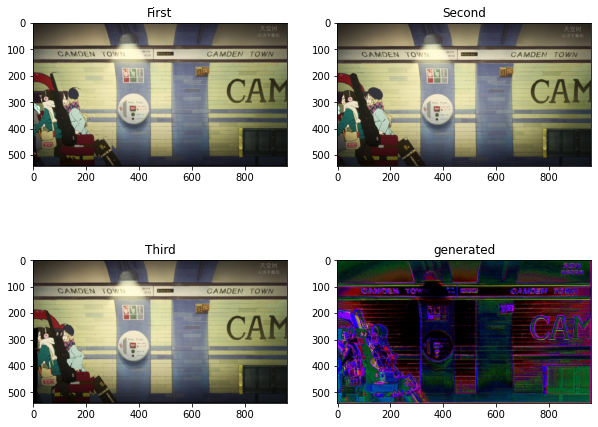

In [8]:
fig = plt.figure(figsize=(10, 8))
fig.add_subplot(2, 2, 1) 
plt.imshow(img1)
plt.title("First")
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.title("Second")
fig.add_subplot(2, 2, 3)
plt.imshow(img3)
plt.title("Third")
fig.add_subplot(2, 2, 4)
plt.imshow(generated)
plt.title("generated")

In [9]:
torch.save(unet.state_dict(), 'weights.pth')